In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import sys
sys.path.append('./src')

from FIESTA_functions import *
from HARPS_N_functions import *
from NEID_solar_functions import *
from GP_kernels import *



In [4]:
#----------------------------------
# Read data
#----------------------------------

v_grid  = np.loadtxt('./lib/data_v4/v_grid.txt')
CCF     = np.loadtxt('./lib/data_v4/CCF.txt')
σCCF   = np.loadtxt('./lib/data_v4/σCCF.txt')
bjd     = np.loadtxt('./lib/data_v4/bjd.txt')
rv      = np.loadtxt('./lib/data_v4/rv.txt')
σrv     = np.loadtxt('./lib/data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('./lib/data_v4/idx_rej'), dtype=bool)

# Examine RVs 2021

### Outliers are present in the original RVs 

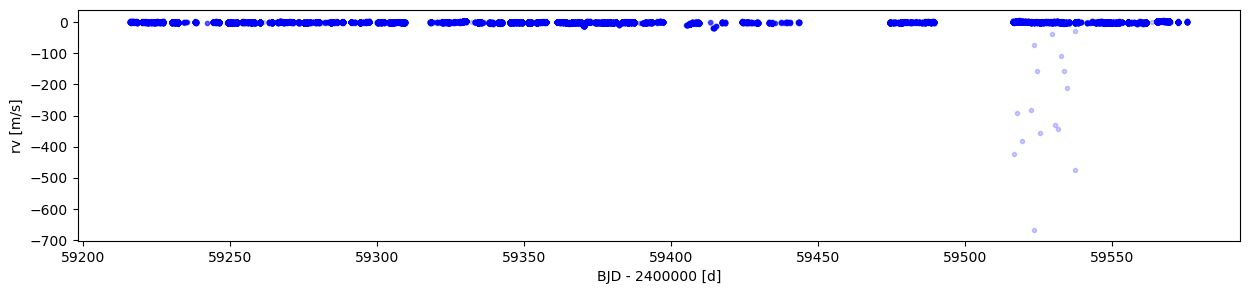

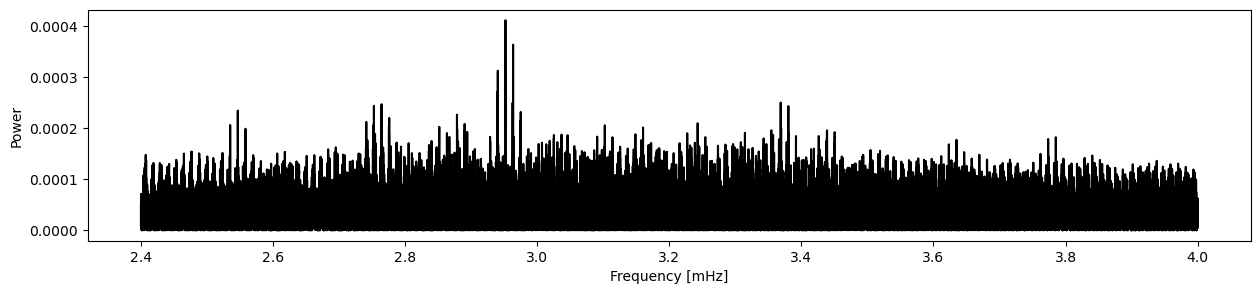

In [5]:
fig, axes = plt.subplots(figsize=(15, 3))
alpha=0.2
plt.plot(bjd-2400000, rv-np.mean(rv), 'b.', alpha=alpha)
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('rv [m/s]')
plt.show()

from astropy.timeseries import LombScargle

plt.subplots(figsize=(15, 3))
plt.rcParams.update({'font.size': 14})

idx_bjd = (~idx_rej)
frequency, power = LombScargle(bjd*24*60, rv, σrv).autopower(minimum_frequency=0.1, maximum_frequency=1, samples_per_peak=10)        

idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx], 'k')
plt.ylabel('Power')
plt.xlabel('Frequency [mHz]')
plt.show()

### Priminarily corrected RV

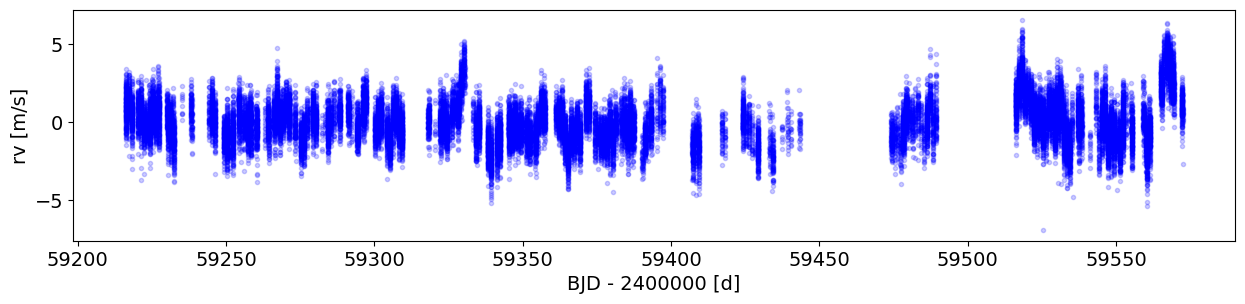

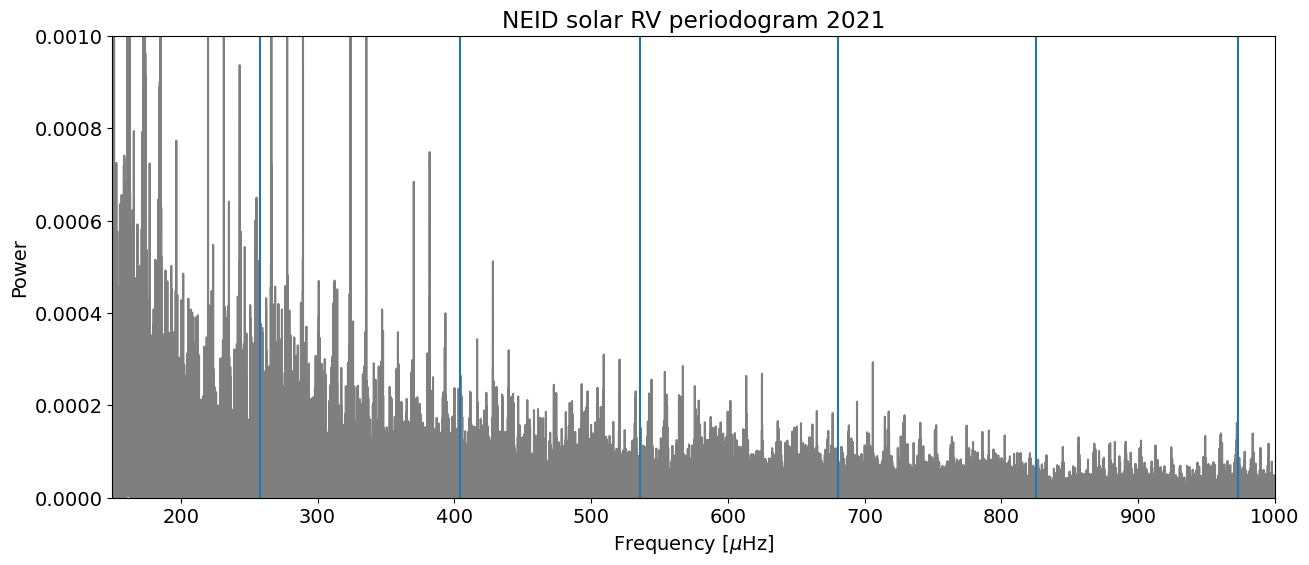

In [27]:
fig, axes = plt.subplots(figsize=(15, 3))
alpha=0.2
plt.plot(bjd[~idx_rej]-2400000, rv[~idx_rej]-np.mean(rv[~idx_rej]), 'b.', alpha=alpha)
plt.xlabel('BJD - 2400000 [d]')
plt.ylabel('rv [m/s]')
plt.show()

from astropy.timeseries import LombScargle

plt.subplots(figsize=(15, 6))
plt.rcParams.update({'font.size': 14})

idx_bjd = (~idx_rej)
frequency, power = LombScargle(bjd[idx_bjd]*24*60*60, rv[idx_bjd], σrv[idx_bjd]).autopower(samples_per_peak=10)
frequency *= 1e6 # microHz
idx = (frequency<1000) & (frequency>150)
plt.plot(frequency[idx], power[idx], 'k', alpha=0.5)
plt.axvline(x=258.0473)
plt.axvline(x=404.5170)
plt.axvline(x=535.9691)
plt.axvline(x=680.5993)
plt.axvline(x=825.3916)
plt.axvline(x=972.7745)
plt.ylabel('Power')
plt.xlim([150,1000])
plt.ylim([0,0.001])
plt.title('NEID solar RV periodogram 2021')
plt.xlabel('Frequency [$\mu$Hz]')
plt.savefig('Figures/NEID solar 2021 Periodogram.png')
plt.show()

### Further daily corrected RV

In [ ]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

bjd_new = []
rv_new = []
σrv_new = []

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    
    if len(bjd[idx_bjd])>50:
        
        t = bjd[idx_bjd]
        y = rv[idx_bjd]
        dy = σrv[idx_bjd]
        
        for i in range(2):
            
            # remove linear trend 
            reg = LinearRegression().fit(t.reshape((-1, 1)), y)
            y = y - reg.predict(t.reshape((-1, 1)))

            # remove 3-singma outliers 

            y_ave = np.mean(y)
            y_std = np.std(y)
            idx_3σ = (y<(y_ave+3*y_std)) & (y>(y_ave-3*y_std))
            
            t = t[idx_3σ]
            y = y[idx_3σ]
            dy = dy[idx_3σ]
            
        bjd_new = np.append(bjd_new, t)
        rv_new = np.append(rv_new, y)
        σrv_new = np.append(σrv_new, dy)


In [ ]:
bjd.shape, bjd_new.shape

In [ ]:
plt.subplots(figsize=(15, 3))
plt.rcParams.update({'font.size': 14})

frequency, power = LombScargle(bjd_new*24*60, rv_new, σrv_new).autopower(minimum_frequency=0.1, maximum_frequency=1, samples_per_peak=10)        
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx], 'k')
plt.ylabel('Power')
plt.xlabel('Frequency [mHz]')
plt.show()

Jacob's dates

In [ ]:
T1 = pyasl.jdcnv(datetime(2021, 1, 1))
T2 = pyasl.jdcnv(datetime(2021, 9, 30))
idx_bjd = (bjd_new>=T1) & (bjd_new<T2+1)

plt.subplots(figsize=(15, 3))
plt.rcParams.update({'font.size': 14})

frequency, power = LombScargle(bjd_new[idx_bjd]*24*60, rv_new[idx_bjd], σrv_new[idx_bjd]).autopower(minimum_frequency=0.1, maximum_frequency=1, samples_per_peak=10)        
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)
plt.plot(frequency[idx]/60*1000, power[idx], 'k')
plt.ylabel('Power')
plt.xlabel('Frequency [mHz]')
plt.show()

### Periodogram on datetime(2021, 6, 1)

In [ ]:
from astropy.timeseries import LombScargle

plt.subplots(figsize=(15, 3))
plt.rcParams.update({'font.size': 14})

date = datetime(2021, 6, 1)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

if sum(bjd[idx_bjd])!=0:
    frequency, power = LombScargle(bjd[idx_bjd]*24*60, rv[idx_bjd], σrv[idx_bjd]).autopower(minimum_frequency=1/400, maximum_frequency=1, samples_per_peak=100)        
    plot_x = 1/frequency
    idx = plot_x<10
    plt.plot(plot_x[idx], power[idx], 'k')
    plt.xlabel('Period [min]')
    plt.ylabel('Power')
plt.show()

# GP analysis

### GP fits for all year

### Include the granulation term

In [ ]:
# nu_max = 3090e-6 #Hz
# omega_1 = 2*np.pi*0.317*nu_max**0.97
# omega_2 = 2*np.pi*0.948*nu_max**0.992
# print(2*np.pi/omega_1/60)
# print(2*np.pi/omega_2/60)

In [ ]:
nu_max = 3140 #μHz
omega_1 = 2*np.pi*0.317*nu_max**0.97 * 60
omega_2 = 2*np.pi*0.948*nu_max**0.992 * 60
print(2*np.pi/omega_1*1e6)
print(2*np.pi/omega_2*1e6)

In [ ]:
0.317*nu_max**0.97, 0.948*nu_max**0.992

In [ ]:
def GP_granulation_fit(t, y, yerr):

    bounds = dict(log_S0=(-15, 15), log_omega0=(-3, 0.5))
    k1 = terms.SHOTerm(log_S0=np.log(S1), log_Q=np.log(Q), log_omega0=np.log(omega_1), bounds=bounds)
    k1.freeze_parameter("log_Q")
    # k1.freeze_parameter("log_S0")
    # k1.freeze_parameter("log_omega0")
    bounds = dict(log_S0=(-15, 15), log_omega0=(-1.5, 1.5))
    k2 = terms.SHOTerm(log_S0=np.log(S2), log_Q=np.log(Q), log_omega0=np.log(omega_2), bounds=bounds)
    k2.freeze_parameter("log_Q")
    # k2.freeze_parameter("log_S0")
    # k2.freeze_parameter("log_omega0")
    # kernel = k1 + k2
    kernel = k2

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


In [ ]:
2*np.pi/5.2, 2*np.pi*0.317*nu_max**0.97*60e-6, 2*np.pi*0.948*nu_max**0.992*60e-6

In [ ]:
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]
# yerr = yerr /2


nu_max = 3090 #μHz
omega_1 = 2*np.pi*0.317*nu_max**0.97
omega_2 = 2*np.pi*0.948*nu_max**0.992
a_n = 3382*nu_max**(-0.609)/100
S1 = a_n**2*np.sqrt(2)/omega_1
S2 = a_n**2*np.sqrt(2)/omega_2
Q = 1/np.sqrt(2)
# Q = 10
omega_1 *= 60e-6 # convert to 1/min
omega_2 *= 60e-6 # convert to 1/min

k1 = terms.SHOTerm(log_S0=np.log(S1), log_Q=np.log(Q), log_omega0=np.log(omega_1))
k2 = terms.SHOTerm(log_S0=np.log(S2), log_Q=np.log(Q), log_omega0=np.log(omega_2))    
kernel = k2
# kernel = k1 + k2
gp_data = celerite.GP(kernel)
gp_data.compute(t, yerr)
y = gp_data.sample()


fig = plt.figure(figsize=(18, 3))
# gp_fit = GP_fit_p1(t, y, yerr, p=10)
gp_fit = GP_granulation_fit(t, y, yerr) 
# gp_fit = GP_fit_Matern52Kernel(t, yerr, r=3)
# gp_fit = GP(t, y, yerr)
x = np.linspace(min(t), max(t), 10*len(t))
pred_mean, pred_var = gp_fit.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)        
plt.plot(x, pred_mean, color='k', alpha=0.3)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                 edgecolor="none")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(t, y)
plt.show()

for key, value in gp_fit.get_parameter_dict().items():
    print(key[11:], '\t:', np.exp(value))
    
print('std =', np.std(y))    

In [ ]:
print(S1,S2)

print(2*np.pi/omega_1, omega_1, np.log(omega_1/5), np.log(omega_1*5))
print(2*np.pi/omega_2, omega_2, np.log(omega_2/5), np.log(omega_2*5))


In [ ]:
pred_mean, pred_var

In [ ]:
gp.sample().shape, t.shape, x.shape

In [ ]:
nu_max = 3090 #μHz
omega_1 = 2*np.pi*0.317*nu_max**0.97
omega_2 = 2*np.pi*0.948*nu_max**0.992
a_n = 3382*nu_max**(-0.609)/100
S1 = a_n**2*np.sqrt(2)/omega_1
S2 = a_n**2*np.sqrt(2)/omega_2
Q = 1/np.sqrt(2)
print(np.log(S1), np.log(S2))

In [ ]:
np.log(21089.33976546218)

In [ ]:
from scipy.signal import hilbert, chirp

def moving_ave(t, y, width=2):
    w_aves = []
    for t_i in t:
        weights = stats.norm.pdf(t, t_i, width)
        # weights = np.multiply(abs(array_x-t_i)<width, 1) 
        w_ave, _ = weighted_avg_and_std(y, weights)
        w_aves.append(w_ave)
        # w_stds.append(w_std)
    return np.array(w_aves)
        

# start_date = datetime(2021, 5, 28)
# end_date = datetime(2021, 5, 30)
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)
P_LL_max = np.zeros((end_date - start_date).days+1)
dP_LL_max = np.zeros((end_date - start_date).days+1)
P_SwQ_min = np.zeros((end_date - start_date).days+1)
dP_SwQ_min = np.zeros((end_date - start_date).days+1)
SwQ_min = np.zeros((end_date - start_date).days+1)

N = 701
p_array = np.linspace(1, 8, num=N)
# Q_array = np.zeros(((end_date - start_date).days+1, N))
p_max_idx = 0

beats_widths = np.array([])
beats_heights = np.array([])
beats_centres = np.array([])

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    
    if (len(bjd[idx_bjd])>150):

        t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
        y = rv[idx_bjd] - np.mean(rv[idx_bjd])
        
        
        # new
        idx_h = (t<max(t)-30) & (t>30)
        t = t[idx_h]
        y = y[idx_h]
        
        
        
        reg = LinearRegression().fit(t.reshape((-1, 1)), y)
        y = y - reg.predict(t.reshape((-1, 1)))
        yerr = σrv[idx_bjd]
        # yerr = (yerr**2 + 0.25**2)**0.5 # new
        
        yerr = yerr[idx_h]
        


        S_array = np.zeros(N)
        ll_array = np.zeros(N)
        
        
        for i in range(N):
            p = p_array[i]
            w0 = 2*np.pi/p
            gp = GP_fit_p1(t, y, yerr, p)

            if 0: # PSD
                omega = np.exp(np.linspace(np.log(0.1), np.log(2), 5000))
                psd = gp.kernel.get_psd(omega)

                plt.plot(omega, psd, color=color)

                plt.yscale("log")
                plt.xscale("log")
                plt.xlim(omega[0], omega[-1])
                plt.xlabel("$\omega$")
                plt.ylabel("$S(\omega)$");
                plt.show()

                print(2*np.pi/omega[k.get_psd(omega)==max(k.get_psd(omega))])

            if 0:
                print('p\t:', p)   
                for key, value in gp.get_parameter_dict().items():
                    print(key[11:], '\t:', np.exp(value))
                print('Period\t:', 2*np.pi/np.exp(value))   
                print('Final log-likelihood:  {0}'.format(gp.log_likelihood(y)))

            S_array[i] = np.exp(gp.get_parameter('kernel:log_S0')) * w0 * np.exp(gp.get_parameter('kernel:log_Q'))
            ll_array[i] = gp.log_likelihood(y)
            # Q_array[p_max_idx, i] = np.exp(gp.get_parameter('kernel:log_Q'))

            
        ############
        # plotting #
        ############
        fig = plt.figure(figsize=(15, 10))
        plt.subplots_adjust(right=0.85, hspace=0.3)
        plt.rcParams.update({'font.size': 14})

        ## Lower panel 
        peaks, _ = find_peaks(ll_array)
        frequency, power = LombScargle(bjd[idx_bjd]*24*60, rv[idx_bjd], σrv[idx_bjd]).autopower(minimum_frequency=1/8, maximum_frequency=1, samples_per_peak=10)        
        plot_x = 1/frequency
        idx = plot_x<8

        # Periodogram
        ax1 = fig.add_subplot(312)
        ax1.set_ylim(bottom=0, top=max(power[idx])*1.05)
        ax1.plot(plot_x[idx], power[idx], 'k', alpha=0.5)
        ax1.set_ylabel('Power')
        ax1.set_xlabel('Period [min]')

        # Log likelihood
        ax2 = ax1.twinx()
        ax2.plot(p_array, ll_array, 'r-', alpha=0.7)
        ax2.plot(p_array[peaks], ll_array[peaks], "ro")
        for peak in peaks:
            ax2.text(p_array[peak], ll_array[peak], str(p_array[peak])[:4], color='red')
        P_LL_max[p_max_idx] = p_array[peak]
        dP_LL_max[p_max_idx] = abs(np.gradient(np.gradient(ll_array))[peak])
        ax2.set_ylabel('Log likelihood', color='r')
        for tl in ax2.get_yticklabels():
            tl.set_color('r')

        # SwQ
        ax3 = ax1.twinx()
        peaks, _ = find_peaks(-S_array)
        ax3.plot(p_array[peaks], S_array[peaks], "bo")
        for peak in peaks:
            ax3.text(p_array[peak], S_array[peak], str(p_array[peak])[:4], color='b')
        SwQ_min[p_max_idx] = S_array[peak]
        P_SwQ_min[p_max_idx] = p_array[peak] 
        dP_SwQ_min[p_max_idx] = abs(np.gradient(np.gradient(S_array))[peak])
        ax3.plot(p_array, S_array, 'b', alpha=0.7)
        # ax3.set_ylim(0.6, 2.3)
        ax3.set_ylabel('$S_0\omega_0Q$', color='b')
        ax3.spines.right.set_position(("axes", 1.1))
        for tl in ax3.get_yticklabels():
            tl.set_color('b')        

        ## Upper panel    
        fig.add_subplot(311)
        plt.title(str(date)[:10])
        plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
        x = np.linspace(min(t), max(t), 1000)
        pred_mean, pred_var = GP_fit_p1(t, y, yerr, P_LL_max[p_max_idx]).predict(y, x, return_var=True)
        pred_std = np.sqrt(pred_var)        
        plt.plot(x, pred_mean, color='k', alpha=0.3)
        plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                         edgecolor="none")
        pred_mean, pred_var = GP_fit_p1(t, y, yerr, P_SwQ_min[p_max_idx]).predict(y, x, return_var=True)
        pred_std = np.sqrt(pred_var)
        plt.plot(x, pred_mean, '--', color='k', alpha=0.3)
        plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='k', alpha=0.1,
                         edgecolor="none")        
        plt.xlabel("Time [min]")
        plt.ylabel("RV [m/s]")
        
        
        
        
        
        Delta_t = np.linspace(0, (max(t)-min(t))-2, 2*len(t))
        cov_XY = []
        for delta_t in Delta_t:
            X = y[t<(max(t)-delta_t)]
            Y, _ = gp.predict(y, t[t<(max(t)-delta_t)]+delta_t, return_var=False)
            cov_XY.append(cov(X, Y))
        cov_XY = np.array(cov_XY)
        analytic_signal = hilbert(cov_XY)
        amplitude_envelope = np.abs(analytic_signal)
        amplitude_envelope = moving_ave(Delta_t, amplitude_envelope, width=5) 
        peaks1, prop1 = find_peaks(amplitude_envelope, height=0.01)  # local max 
        peaks2, prop2 = find_peaks(-amplitude_envelope, height=-10) # local min 
        

        fig.add_subplot(313)
        plt.plot(Delta_t, cov_XY, 'k.-', alpha=0.5)
        plt.plot(Delta_t, amplitude_envelope, 'm', lw=3, alpha=0.4)
        plt.plot(Delta_t, -amplitude_envelope, 'm', lw=3, alpha=0.4)
        plt.plot(Delta_t[peaks1], prop1['peak_heights'], 'o', color='green', markersize=8)
        plt.plot(Delta_t[peaks1], -prop1['peak_heights'], 'o', color='green', markersize=8)
        plt.plot(Delta_t[peaks2], prop2['peak_heights'], 'o', color='red', markersize=8)
        plt.plot(Delta_t[peaks2], -prop2['peak_heights'], 'o', color='red', markersize=8)    
        plt.xlabel(r'$\Delta$T [minutes]')
        plt.ylabel(r'Covariance [m$^2$/s$^2$]')
        plt.grid()    
        plt.show()
        
        
        
        
        
        
        plt.savefig('./figure2/'+str(date)[:10]+'.png')
        plt.show()
        
        

        if 0: 
            fig = plt.figure(figsize=(18, 3))
            _ = plt.hist(rv[idx_bjd]-np.median(rv), bins=20, alpha=0.5)
            plt.title('RV histogram')
            plt.show()

            fig = plt.figure(figsize=(18, 3))
            _ = plt.hist(yerr, bins=20, alpha=0.5)
            plt.title('RV uncertainty histogram')
            # _ = plt.hist( (yerr**2-min(yerr)**2)**0.5, bins=20, alpha=0.5)
            plt.show()        
            

        if 0:
            if len(prop1['peak_heights']) == len(np.diff(Delta_t[peaks2])):
                beats_heights = np.hstack((beats_heights, prop1['peak_heights']))
                beats_widths = np.hstack((beats_widths, np.diff(Delta_t[peaks2])))
                beats_centres = np.hstack((beats_centres, Delta_t[peaks1]))

            if len(prop1['peak_heights']) == (len(np.diff(Delta_t[peaks2]))+1):
                beats_heights = np.hstack((beats_heights, prop1['peak_heights'][:-1]))
                beats_widths = np.hstack((beats_widths, np.diff(Delta_t[peaks2])))    
                beats_centres = np.hstack((beats_centres, Delta_t[peaks1][:-1]))    
        if 1: # just getting the envelope peak centre position 
            beats_centres = np.hstack((beats_centres, Delta_t[peaks1]))
            beats_heights = np.hstack((beats_heights, prop1['peak_heights']))
            
    p_max_idx+=1



In [ ]:
%matplotlib widget
bw = beats_widths
bh = beats_heights

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')
# plt.title(r'Q={:d}, $\omega_0={:.2f}$'.format(Q, w0))
ax.scatter(bw, bh, beats_centres, c = 'b', marker='o')
ax.set_xlabel('widths')
ax.set_ylabel('heights')
ax.set_zlabel(r'$\Delta T$')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
plt.hist(beats_centres, bins = 20)
plt.show()

In [ ]:
bw.shape

In [ ]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

fig = plt.figure(figsize=(15, 6))
plt.rcParams.update({'font.size': 14})

ax1 = fig.add_subplot(211)
dates = [start_date+timedelta(i) for i in range((end_date-start_date).days+1)]
idx = (P_LL_max!=0)
# idx = (P_LL_max!=0) & (np.array(dates)<=datetime(2021, 6, 30))
ax1.errorbar(np.array(dates)[idx], P_LL_max[idx], 1/dP_LL_max[idx]**0.5/300,  marker='o', ms=5, color='red', ls='-', alpha=0.7)
ax1.errorbar(np.array(dates)[idx], P_SwQ_min[idx], 1/dP_SwQ_min[idx]**0.5/2000, marker='s', ms=5, color='b', ls='-', alpha=0.7)
ax1.set_ylabel('Period [min]')

ax2 = fig.add_subplot(212)
ax2.plot(np.array(dates)[idx], SwQ_min[idx], "g-.^", alpha=0.7)
ax2.set_ylabel('SwQ', color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')

# plt.savefig('./figure/Period_SwQ_2021_01-06_dt.png')
plt.savefig('./figure/Period_SwQ_2021_dt.png')

In [ ]:
print(np.median(P_LL_max[idx]))
plt.hist(P_LL_max[idx], 15)

In [ ]:
min(SwQ_min[idx]), max(SwQ_min[idx])

In [ ]:
def Periodogram_SwQ(dates, SwQ, title):

    plt.subplots(figsize=(15, 3))
    plt.rcParams.update({'font.size': 14})

    frequency, power = LombScargle(dates, SwQ).autopower(minimum_frequency=1/(max(dates)-min(dates)), maximum_frequency=1, samples_per_peak=10)
    probabilities = [0.1, 0.05, 0.01]
    print(LombScargle(dates, SwQ).false_alarm_level(probabilities))
    plot_x = 1/frequency
    idx = (plot_x<50) & (plot_x>1)
    plt.plot(plot_x[idx], power[idx], 'k')
    plt.xlabel('Period [day]')
    plt.ylabel('Power')
    plt.xscale('log')        

    peaks, _ = find_peaks(power[idx])
    for peak in peaks:
        if ((plot_x[idx][peak]<7) & (power[idx][peak]>0.05)) | ((plot_x[idx][peak]>7) & (power[idx][peak]>0.03)):
            plt.plot(plot_x[idx][peak], power[idx][peak], "go", alpha=0.5)
            plt.text(plot_x[idx][peak], power[idx][peak], str(plot_x[idx][peak])[:4], color='g')

    plt.title(title)
    plt.show()

In [ ]:
bjd_int = np.array([pyasl.jdcnv(date) for date in dates])

Periodogram_SwQ(dates=bjd_int[idx], SwQ=SwQ_min[idx], title='SwQ_min')

In [ ]:
plt.plot(P_LL_max[idx&(P_LL_max>4)], P_SwQ_min[idx&(P_LL_max>4)], '.')
plt.xlabel('Period (log-likelihood) [d]')
plt.ylabel('Period (kernel) [d]')
plt.show()

plt.plot(P_LL_max[idx&(P_LL_max>4)], SwQ_min[idx&(P_LL_max>4)], '.')
plt.xlabel('Period (log-likelihood) [d]')
plt.ylabel('SwQ')
plt.show()

plt.plot(P_SwQ_min[idx&(P_LL_max>4)], SwQ_min[idx&(P_LL_max>4)], '.')
plt.xlabel('Period (kernel) [d]')
plt.ylabel('SwQ')
plt.show()

### Generate a video

In [ ]:
import cv2
import numpy as np
import glob

img_array = []
for filename in glob.glob('figure2/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

# I (continued)

### include more terms in the GP

### Plot loglikelyhood vs Q - datetime(2021, 5, 28)

In [ ]:
# 2 * np.pi / np.exp(gp_cv.get_parameter('kernel:terms[0]:log_omega0')), 2 * np.pi / np.exp(gp_cv.get_parameter('kernel:terms[1]:log_omega0'))

In [ ]:
# gp_cv.get_parameter_dict()

### 3 frequency modes

In [ ]:
import numpy as np

from scipy.optimize import minimize
from datetime import timedelta, date
from datetime import datetime
from scipy import stats
import random
from sklearn.model_selection import KFold

def GP_fit_Q1(t, y, yerr, Q):
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/7), np.log(2*np.pi/3)))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    # kernel.freeze_parameter("log_omega0")
    kernel.freeze_parameter("log_Q")

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

def sample_ts(t, y, yerr, n_splits, test_portion):
    '''
        Return a consecutive subsample specified by test_portion.
    '''
    i = -1
    kf = KFold(n_splits)
    for train_index, test_index in kf.split(np.arange(len(t))):
        i+=1
        if (i==test_portion):
            t_train, y_train, yerr_train = t[train_index], y[train_index], yerr[train_index]
            t_test, y_test, yerr_test = t[test_index], y[test_index], yerr[test_index]
            return t_train, y_train, yerr_train, t_test, y_test, yerr_test

In [ ]:
# from sklearn.model_selection import train_test_split
        



# def GP(t, y, yerr, Q):
#     '''
#         2/3 frequency modes
#     '''
#     S0 = np.var(y) / (w0 * Q)
#     bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/7), np.log(2*np.pi/3)))
#     # k1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/5.2599166787118765), bounds=bounds)
#     k2 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/((1/(3033.754/10**6)/60))), bounds=bounds)
#     k3 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/((1/(3303.520/10**6)/60))), bounds=bounds)
#     # k1.freeze_parameter("log_Q")
#     # k1.freeze_parameter("log_omega0")
#     k2.freeze_parameter("log_Q")
#     k2.freeze_parameter("log_omega0")
#     k3.freeze_parameter("log_Q")
#     k3.freeze_parameter("log_omega0")
#     # kernel = k1 + k2 + k3
#     kernel = k2 + k3

#     gp = celerite.GP(kernel, mean=np.mean(y))
#     gp.compute(t, yerr)  # You always need to call compute once.

#     initial_params = gp.get_parameter_vector()
#     bounds = gp.get_parameter_bounds()

#     r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
#     gp.set_parameter_vector(r.x)
    
#     return gp


# date = datetime(2021, 1, 12)
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

Q = np.exp(np.linspace(np.log(1),np.log(300),30))

# S_array = np.zeros(len(Q))
ll_array = np.zeros(len(Q))
w0 = 2*np.pi/5

######
# CV #
######
rms_mean = [] 
kf = KFold(10)
for i in range(len(Q)):

    gp = GP_fit_Q1(t, y, yerr, Q[i])

    # SwQ
    # S_array[i] = np.exp(gp.get_parameter('kernel:log_S0')) * np.exp(gp.get_parameter('kernel:log_omega0')) * Q[i]
    # S_array[i] = np.exp(gp.get_parameter('kernel:terms[0]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[0]:log_omega0')) * Q[i] \
    #             + np.exp(gp.get_parameter('kernel:terms[1]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[1]:log_omega0')) * Q[i] \
    #             + np.exp(gp.get_parameter('kernel:terms[2]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[2]:log_omega0')) * Q[i]

    # log-likelihoood 
    ll_array[i] = gp.log_likelihood(y)
    
    # rms 
    rms = []
    
    for train_index, test_index in kf.split(np.arange(len(t))):
        t_train, y_train, yerr_train = t[train_index], y[train_index], yerr[train_index]
        t_test, y_test, yerr_test = t[test_index], y[test_index], yerr[test_index]
    
        gp_cv = GP_fit_Q1(t_train, y_train, yerr_train, Q[i])
        y_pred, _ = gp_cv.predict(y_train, t_test, return_var=True)
        rms.append(np.average((y_pred - y_test)**2, weights=1/yerr_test**2)**0.5)
        
    rms_mean.append(np.mean(rms))
rms_mean = np.array(rms_mean)
    
    
for i in range(len(Q)):    
        
    ############
    # plotting #
    ############
    fig = plt.figure(figsize=(18, 8))
    plt.subplots_adjust(right=0.85, hspace=0.4)
    plt.rcParams.update({'font.size': 14})
    
    ## Lower panel 
    ax1 = fig.add_subplot(313)
    ax1.plot(Q, ll_array, 'r-', alpha=0.7)
    ax1.plot(Q[i], ll_array[i], "ro")
    idx_m = (ll_array==max(ll_array))
    ax1.plot(Q[idx_m], ll_array[idx_m], "rx")
    ax1.text(Q[idx_m], ll_array[idx_m], str(Q[idx_m][0])[:4], color='r')
    ax1.set_ylabel('Log likelihood', color='r')
    for tl in ax1.get_yticklabels():
        tl.set_color('r')
    ax1.set_xlabel('Q')
    ax1.set_xscale('log')  
    
#     # SwQ
#     ax3 = ax1.twinx()
#     peaks, _ = find_peaks(-S_array)
#     ax3.plot(Q, S_array, 'b', alpha=0.7)
#     ax3.plot(Q[i], S_array[i], "bo")
#     idx_m = (S_array==min(S_array))
#     ax3.plot(Q[idx_m], S_array[idx_m], "bx")
#     ax3.text(Q[idx_m], S_array[idx_m], str(Q[idx_m][0])[:4], color='b')    
#     ax3.set_ylabel('$S_0\omega_0Q$', color='b')
#     for tl in ax3.get_yticklabels():
#         tl.set_color('b')        
#     ax3.set_xscale('log')    
    
    # rms
    ax4 = ax1.twinx()
    ax4.plot(Q, rms_mean, 'g', alpha=0.7)
    ax4.plot(Q[i], rms_mean[i], "go")
    idx_m = (rms_mean==min(rms_mean))
    ax4.plot(Q[idx_m], rms_mean[idx_m], "gx")
    ax4.text(Q[idx_m], rms_mean[idx_m], str(Q[idx_m][0])[:4], color='g')        
    ax4.set_ylabel('rms [m/s]', color='g')
    ax4.spines.right.set_position(("axes", 1.1))
    for tl in ax4.get_yticklabels():
        tl.set_color('g')
    ax4.set_xscale('log')    
        
    ## Upper panel    
    fig.add_subplot(311)
    plt.title(str(date)[:10])
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    
    # if 0: # left out because we want to focus on the...
    x = np.linspace(min(t), max(t), 1000)
    gp = GP_fit_Q1(t, y, yerr, Q[i])
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp.predict(y, t)
    res = pred_y - y
    # plt.plot(x, pred_mean, '--', color='r', alpha=0.3)
    y_range = max(y) - min(y)
    plt.ylim(min(y)-0.1*y_range, max(y)+0.1*y_range)
    # plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='r', alpha=0.1,
    #                  edgecolor="none")
    
    t_train, y_train, yerr_train, t_test, y_test, yerr_test = sample_ts(t, y, yerr, 20, 14)
    gp_cv = GP_fit_Q1(t_train, y_train, yerr_train, Q[i])
    pred_mean, pred_var = gp_cv.predict(y_train, x, return_var=True)  
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp_cv.predict(y_train, t_test)
    res_cv = pred_y - y_test
    plt.plot(x, pred_mean, '--', color='g', alpha=0.3)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='g', alpha=0.1,
                     edgecolor="none")
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")

    # Middle panel
    fig.add_subplot(312)
    plt.errorbar(t, res, yerr=yerr, fmt=".r", capsize=0, alpha=0.8, label=str('GP wrms={:.3f}'.format(np.average(res**2, weights=1/yerr**2)**0.5)))
    plt.errorbar(t_test, res_cv, yerr=yerr_test, fmt=".g", capsize=0, alpha=0.8, label=str('CV wrms={:.3f}'.format(np.average(res_cv**2, weights=1/yerr_test**2)**0.5)))
    plt.legend(bbox_to_anchor =(1.2, 0.5))
    plt.xlabel("Time [min]")
    plt.ylabel("Residual RV [m/s]")
    
    plt.savefig('./figure3_3/'+str(i)+'.png')
    # if (i%int(len(Q)/3) == 0):
    #     plt.show()
    # else:
    #     plt.close()
    plt.show()

In [ ]:
t.shape

In [ ]:

def GP_fit_Q1(t, y, yerr, Q):
    w0 = 2*np.pi/5
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/7), np.log(2*np.pi/3)))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    # kernel.freeze_parameter("log_omega0")
    kernel.freeze_parameter("log_Q")

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

# date = datetime(2021, 1, 12)
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

# New #
# idx_half = (t < max(t)/2)
# t = t[idx_half]
# y = y[idx_half]
# yerr = yerr[idx_half]
#

Q = np.exp(np.linspace(np.log(1),np.log(300),30))
w0 = 2*np.pi/5

# S_array = np.zeros(len(Q))
ll_array = np.zeros(len(Q))

######
# CV #
######
rms_mean = [] 
kf = KFold(10)
for i in range(len(Q)):

    gp = GP_fit_Q1(t, y, yerr, Q[i])

    # SwQ
    # S_array[i] = np.exp(gp.get_parameter('kernel:log_S0')) * np.exp(gp.get_parameter('kernel:log_omega0')) * Q[i]
    # S_array[i] = np.exp(gp.get_parameter('kernel:terms[0]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[0]:log_omega0')) * Q[i] \
    #             + np.exp(gp.get_parameter('kernel:terms[1]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[1]:log_omega0')) * Q[i] \
    #             + np.exp(gp.get_parameter('kernel:terms[2]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[2]:log_omega0')) * Q[i]

    # log-likelihoood 
    ll_array[i] = gp.log_likelihood(y)
    
    # rms 
    rms = []
    
    for train_index, test_index in kf.split(np.arange(len(t))):
        t_train, y_train, yerr_train = t[train_index], y[train_index], yerr[train_index]
        t_test, y_test, yerr_test = t[test_index], y[test_index], yerr[test_index]
    
        gp_cv = GP_fit_Q1(t_train, y_train, yerr_train, Q[i])
        y_pred, _ = gp_cv.predict(y_train, t_test, return_var=True)
        rms.append(np.average((y_pred - y_test)**2, weights=1/yerr_test**2)**0.5)
        
    rms_mean.append(np.mean(rms))
rms_mean = np.array(rms_mean)
    
    
for i in range(len(Q)):    
        
    ############
    # plotting #
    ############
    fig = plt.figure(figsize=(18, 8))
    plt.subplots_adjust(right=0.85, hspace=0.4)
    plt.rcParams.update({'font.size': 14})
    
    ## Lower panel 
    ax1 = fig.add_subplot(313)
    ax1.plot(Q, ll_array, 'r-', alpha=0.7)
    ax1.plot(Q[i], ll_array[i], "ro")
    idx_m = (ll_array==max(ll_array))
    ax1.plot(Q[idx_m], ll_array[idx_m], "rx")
    ax1.text(Q[idx_m], ll_array[idx_m], str(Q[idx_m][0])[:4], color='r')
    ax1.set_ylabel('Log likelihood', color='r')
    for tl in ax1.get_yticklabels():
        tl.set_color('r')
    ax1.set_xlabel('Q')
    ax1.set_xscale('log')  
    
#     # SwQ
#     ax3 = ax1.twinx()
#     peaks, _ = find_peaks(-S_array)
#     ax3.plot(Q, S_array, 'b', alpha=0.7)
#     ax3.plot(Q[i], S_array[i], "bo")
#     idx_m = (S_array==min(S_array))
#     ax3.plot(Q[idx_m], S_array[idx_m], "bx")
#     ax3.text(Q[idx_m], S_array[idx_m], str(Q[idx_m][0])[:4], color='b')    
#     ax3.set_ylabel('$S_0\omega_0Q$', color='b')
#     for tl in ax3.get_yticklabels():
#         tl.set_color('b')        
#     ax3.set_xscale('log')    
    
    # rms
    ax4 = ax1.twinx()
    ax4.plot(Q, rms_mean, 'g', alpha=0.7)
    ax4.plot(Q[i], rms_mean[i], "go")
    idx_m = (rms_mean==min(rms_mean))
    ax4.plot(Q[idx_m], rms_mean[idx_m], "gx")
    ax4.text(Q[idx_m], rms_mean[idx_m], str(Q[idx_m][0])[:4], color='g')        
    ax4.set_ylabel('rms [m/s]', color='g')
    ax4.spines.right.set_position(("axes", 1.1))
    for tl in ax4.get_yticklabels():
        tl.set_color('g')
    ax4.set_xscale('log')    
        
    ## Upper panel    
    fig.add_subplot(311)
    plt.title(str(date)[:10])
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    
    # if 0: # left out because we want to focus on the...
    x = np.linspace(min(t), max(t), 1000)
    gp = GP_fit_Q1(t, y, yerr, Q[i])
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp.predict(y, t)
    res = pred_y - y
    # plt.plot(x, pred_mean, '--', color='r', alpha=0.3)
    y_range = max(y) - min(y)
    plt.ylim(min(y)-0.1*y_range, max(y)+0.1*y_range)
    # plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='r', alpha=0.1,
    #                  edgecolor="none")
    
    t_train, y_train, yerr_train, t_test, y_test, yerr_test = sample_ts(t, y, yerr, 10, 7)
    gp_cv = GP_fit_Q1(t_train, y_train, yerr_train, Q[i])
    pred_mean, pred_var = gp_cv.predict(y_train, x, return_var=True)  
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp_cv.predict(y_train, t_test)
    res_cv = pred_y - y_test
    plt.plot(x, pred_mean, '--', color='g', alpha=0.3)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='g', alpha=0.1,
                     edgecolor="none")
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")

    # Middle panel
    fig.add_subplot(312)
    plt.errorbar(t, res, yerr=3*yerr, fmt=".r", capsize=0, alpha=0.8, label=str('GP wrms={:.3f}'.format(np.average(res**2, weights=1/yerr**2)**0.5)))
    plt.errorbar(t_test, res_cv, yerr=3*yerr_test, fmt=".g", capsize=0, alpha=0.8, label=str('CV wrms={:.3f}'.format(np.average(res_cv**2, weights=1/yerr_test**2)**0.5)))
    plt.legend(bbox_to_anchor =(1.2, 0.5))
    plt.xlabel("Time [min]")
    plt.ylabel("Residual RV [m/s]")
    
    plt.savefig('./figure3_3/'+str(i)+'.png')
    if (i%int(len(Q)/3) == 0):
        plt.show()
    else:
        plt.close()
    # plt.show()

### 6 frequency modes

In [ ]:
idx_bjd = (~idx_rej)
frequency, power = LombScargle(bjd[idx_bjd]*24*60, rv[idx_bjd], σrv[idx_bjd]).autopower(minimum_frequency=0.1, maximum_frequency=1, samples_per_peak=10)   
idx = (frequency/60*1000<4) & (frequency/60*1000>2.4)

In [ ]:
plt.subplots(figsize=(18, 4))
plt.rcParams.update({'font.size': 14})

plt.plot(frequency[idx]/60*1000, power[idx], 'k')
alpha=0.7
for x in [2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520e-3]: # , 3303.520e-3
    plt.axvline(x = x, color = 'g', label='l=0', alpha=alpha)
for x in [2828.150e-3, 2963.322e-3, 3098.140e-3, 3233.139e-3]: # , 3303.520e-3
    plt.axvline(x = x, color = 'r', label='l=1', alpha=alpha)    
for x in [2889.578e-3, 3024.689e-3, 3159.821e-3]: # , 3303.520e-3
    plt.axvline(x = x, color = 'purple', label='l=2', alpha=alpha)        
plt.legend()    
plt.ylabel('Power')
plt.xlabel('Frequency [mHz]')
plt.show()

In [ ]:
1/(5.31*60)*1000

In [ ]:
# from sklearn.model_selection import train_test_split
import random
import george
from george import kernels
from sklearn.model_selection import KFold






        
def GP(t, y, yerr, Q):
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/7), np.log(2*np.pi/3)))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    # kernel.freeze_parameter("log_omega0")
    kernel.freeze_parameter("log_Q")

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


# def GP(t, y, yerr, Q):
#     '''
#         6/8 frequency modes
#     '''
#     S0 = np.var(y) / (w0 * Q)
#     bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
#     k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
#     k02 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
#     k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
#     k04 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
#     k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
#     k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
#     k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
#     k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
#     k01.freeze_parameter("log_Q")
#     k01.freeze_parameter("log_omega0")
#     k02.freeze_parameter("log_Q")
#     k02.freeze_parameter("log_omega0")
#     k03.freeze_parameter("log_Q")
#     k03.freeze_parameter("log_omega0")
#     k04.freeze_parameter("log_Q")
#     k04.freeze_parameter("log_omega0")
#     k11.freeze_parameter("log_Q")
#     k11.freeze_parameter("log_omega0")
#     k12.freeze_parameter("log_Q")
#     k12.freeze_parameter("log_omega0")    
#     k13.freeze_parameter("log_Q")
#     k13.freeze_parameter("log_omega0")    
#     k14.freeze_parameter("log_Q")
#     k14.freeze_parameter("log_omega0")
#     # kernel = k01 + k02 + k03 + k11 + k12 + k13
#     kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

#     gp = celerite.GP(kernel, mean=np.mean(y))
#     gp.compute(t, yerr)  # You always need to call compute once.

#     initial_params = gp.get_parameter_vector()
#     bounds = gp.get_parameter_bounds()

#     r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
#     gp.set_parameter_vector(r.x)
    
#     return gp


# date = datetime(2021, 1, 12)
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

Q = np.exp(np.linspace(np.log(1),np.log(20),20))
# Q = np.array([20])

S_array = np.zeros(len(Q))
ll_array = np.zeros(len(Q))
w0 = 2*np.pi/5

for i in range(len(Q)):
    
    gp = GP(t, y, yerr, Q[i])

    # S_array[i] = np.exp(gp.get_parameter('kernel:log_S0')) * np.exp(gp.get_parameter('kernel:log_omega0')) * Q[i]
    S_array[i] = np.exp(gp.get_parameter('kernel:terms[0]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[0]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[1]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[1]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[2]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[2]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[3]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[3]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[4]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[4]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[5]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[5]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[6]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[6]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[7]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[7]:log_omega0')) * Q[i]
    
                # + np.exp(gp.get_parameter('kernel:terms[8]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[8]:log_omega0')) * Q[i] \
    
    # OrderedDict([('kernel:terms[0]:log_S0', -2.0987982204314046),
    #              ('kernel:terms[0]:log_omega0', 0.18550353741311448),
    #              ('kernel:terms[1]:log_S0', -2.0987982204314046),
    #              ('kernel:terms[1]:log_omega0', 0.18550353741311448)])

    ll_array[i] = gp.log_likelihood(y)

######
# CV #
######
rms_mean = [] 
kf = KFold(10)
for i in range(len(Q)):
    rms = []
        
    for train_index, test_index in kf.split(np.arange(len(t))):
        t_train, y_train, yerr_train = t[train_index], y[train_index], yerr[train_index]
        t_test, y_test, yerr_test = t[test_index], y[test_index], yerr[test_index]
    
        gp_cv = GP(t_train, y_train, yerr_train, Q[i])
        y_pred, _ = gp_cv.predict(y_train, t_test, return_var=True)
        rms.append(np.average((y_pred - y_test)**2, weights=1/yerr_test**2)**0.5)
        
    rms_mean.append(np.mean(rms))
rms_mean = np.array(rms_mean)
    
    
for i in range(len(Q)):    
        
    ############
    # plotting #
    ############
    fig = plt.figure(figsize=(18, 8))
    plt.subplots_adjust(right=0.85, hspace=0.4)
    plt.rcParams.update({'font.size': 14})
    
    ## Lower panel 
    ax1 = fig.add_subplot(313)
    ax1.plot(Q, ll_array, 'r-', alpha=0.7)
    ax1.plot(Q[i], ll_array[i], "ro")
    idx_m = (ll_array==max(ll_array))
    ax1.plot(Q[idx_m], ll_array[idx_m], "rx")
    ax1.text(Q[idx_m], ll_array[idx_m], str(Q[idx_m][0])[:4], color='r')
    ax1.set_ylabel('Log likelihood', color='r')
    for tl in ax1.get_yticklabels():
        tl.set_color('r')
    ax1.set_xlabel('Q')
    ax1.set_xscale('log')  
    
    # SwQ
    ax3 = ax1.twinx()
    peaks, _ = find_peaks(-S_array)
    ax3.plot(Q, S_array, 'b', alpha=0.7)
    ax3.plot(Q[i], S_array[i], "bo")
    idx_m = (S_array==min(S_array))
    ax3.plot(Q[idx_m], S_array[idx_m], "bx")
    ax3.text(Q[idx_m], S_array[idx_m], str(Q[idx_m][0])[:4], color='b')    
    ax3.set_ylabel('$S_0\omega_0Q$', color='b')
    for tl in ax3.get_yticklabels():
        tl.set_color('b')        
    ax3.set_xscale('log')    
    
    # rms
    ax4 = ax1.twinx()
    ax4.plot(Q, rms_mean, 'g', alpha=0.7)
    ax4.plot(Q[i], rms_mean[i], "go")
    idx_m = (rms_mean==min(rms_mean))
    ax4.plot(Q[idx_m], rms_mean[idx_m], "gx")
    ax4.text(Q[idx_m], rms_mean[idx_m], str(Q[idx_m][0])[:4], color='g')        
    ax4.set_ylabel('rms [m/s]', color='g')
    ax4.spines.right.set_position(("axes", 1.1))
    for tl in ax4.get_yticklabels():
        tl.set_color('g')
    ax4.set_xscale('log')    
        
    ## Upper panel    
    fig.add_subplot(311)
    plt.title(str(date)[:10])
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    
    # if 0: # left out because we want to focus on the...
    x = np.linspace(min(t), max(t), 1000)
    gp = GP(t, y, yerr, Q[i])
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp.predict(y, t)
    res = pred_y - y
    # plt.plot(x, pred_mean, '--', color='r', alpha=0.3)
    y_range = max(y) - min(y)
    plt.ylim(min(y)-0.1*y_range, max(y)+0.1*y_range)
    # plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='r', alpha=0.1,
    #                  edgecolor="none")
    
    t_train, y_train, yerr_train, t_test, y_test, yerr_test = sample_ts(t, y, yerr, 10, 5)
    gp_cv = GP(t_train, y_train, yerr_train, Q[i])
    pred_mean, pred_var = gp_cv.predict(y_train, x, return_var=True)  
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp_cv.predict(y_train, t_test)
    res_cv = pred_y - y_test
    plt.plot(x, pred_mean, '--', color='g', alpha=0.3)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='g', alpha=0.1,
                     edgecolor="none")
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")

    # Middle panel
    fig.add_subplot(312)
    plt.errorbar(t, res, yerr=yerr, fmt=".r", capsize=0, alpha=0.8, label=str('GP wrms={:.3f}'.format(np.average(res**2, weights=1/yerr**2)**0.5)))
    plt.errorbar(t_test, res_cv, yerr=yerr_test, fmt=".g", capsize=0, alpha=0.8, label=str('CV wrms={:.3f}'.format(np.average(res_cv**2, weights=1/yerr_test**2)**0.5)))
    plt.legend(bbox_to_anchor =(1.2, 0.5))
    plt.xlabel("Time [min]")
    plt.ylabel("Residual RV [m/s]")

    plt.savefig('./figure3_6/'+str(i)+'.png')
    plt.show()
    
    S0 = np.array([(np.exp(gp.get_parameter('kernel:terms[' + str(j) + ']:log_S0'))) for j in range(len(gp))])
    S0
    
    # X_axis = ['l01', 'l02', 'l03', 'l11', 'l12', 'l13']
    X_axis = ['l01', 'l02', 'l03', 'l04', 'l11', 'l12', 'l13', 'l14']
    plt.plot(X_axis, S0, 'o')
    plt.yscale('log')
    plt.show()
    # if (i%int(len(Q)/3) == 0):
    #     plt.show()
    # else:
    #     plt.close()



In [ ]:
frequency, power = LombScargle(bjd[idx_bjd]*24*60, rv[idx_bjd], σrv[idx_bjd]).autopower(minimum_frequency=1/200, maximum_frequency=1, samples_per_peak=10)        
plot_x = 1/frequency
idx = (plot_x<200)# & (plot_x>10) 

# Periodogram
# ax1.set_ylim(bottom=0, top=max(power[idx])*1.05)
fig = plt.figure(figsize=(18, 3))
plt.plot(plot_x[idx], power[idx], 'k', alpha=0.5)
plt.ylabel('Power')
plt.xlabel('Period [min]')
plt.xscale('log')
plt.show()

In [ ]:
1/(80*60)*1000

### Remove the long-term varation trend 

In [ ]:
def long_short_divide(x, y, yerr, r):
	'''
	x 		= bjd_daily
	y 		= shift_function[i,:]
	yerr 	= err_shift_spectrum[i,:]
	'''

	import george
	from george import kernels

	kernel 	= np.var(y) * kernels.Matern52Kernel(r**2)
	gp 		= george.GP(kernel)
	gp.compute(x, yerr)

	y_pred, _ 	= gp.predict(y, x, return_var=True)
	long_term 	= y_pred
	short_term 	= y - y_pred

	return gp, short_term, long_term


date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

_, short_variation, long_variation = long_short_divide(x=t, y=y, yerr=yerr, r=10)
    
fig = plt.figure(figsize=(18, 3))
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(t, long_variation, lw=5, alpha=0.2)
plt.title('RV')
plt.show()

fig = plt.figure(figsize=(18, 3))
plt.errorbar(t, short_variation, yerr=yerr, fmt=".k", capsize=0)
plt.title('Residual RV')
plt.show()

# Periodogram
for y in [y, short_variation, long_variation, np.ones(len(y))]:
    fig = plt.figure(figsize=(18, 3))
    frequency, power = LombScargle(t, y, yerr).autopower(maximum_frequency=1, samples_per_peak=10)        
    plot_x = 1/frequency
    idx = (plot_x<200) 

    plt.plot(plot_x[idx], power[idx], 'k', alpha=0.5)
    plt.ylim(bottom=0, top=max(power[idx])*1.05)    
    plt.ylabel('Power')
    plt.xlabel('Period [min]')
    plt.xscale('log')
    plt.show()     

In [ ]:
def GP(t, y, yerr, Q):
    '''
        2/3 frequency modes
    '''
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_omega0")
    k03.freeze_parameter("log_Q")
    k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_omega0")
    k11.freeze_parameter("log_Q")
    k11.freeze_parameter("log_omega0")
    k12.freeze_parameter("log_Q")
    k12.freeze_parameter("log_omega0")    
    k13.freeze_parameter("log_Q")
    k13.freeze_parameter("log_omega0")    
    k14.freeze_parameter("log_Q")
    k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

y = short_variation
Q = np.exp(np.linspace(np.log(1),np.log(200),20))

S_array = np.zeros(len(Q))
ll_array = np.zeros(len(Q))
w0 = 2*np.pi/5

for i in range(len(Q)):
    
    gp = GP(t, y, yerr, Q[i])

    S_array[i] = np.exp(gp.get_parameter('kernel:terms[0]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[0]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[1]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[1]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[2]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[2]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[3]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[3]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[4]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[4]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[5]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[5]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[6]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[6]:log_omega0')) * Q[i] \
                + np.exp(gp.get_parameter('kernel:terms[7]:log_S0')) * np.exp(gp.get_parameter('kernel:terms[7]:log_omega0')) * Q[i]
    
    ll_array[i] = gp.log_likelihood(y)

######
# CV #
######
rms_mean = [] 
kf = KFold(10)
for i in range(len(Q)):
    rms = []
        
    for train_index, test_index in kf.split(np.arange(len(t))):
        t_train, y_train, yerr_train = t[train_index], y[train_index], yerr[train_index]
        t_test, y_test, yerr_test = t[test_index], y[test_index], yerr[test_index]
    
        gp_cv = GP(t_train, y_train, yerr_train, Q[i])
        y_pred, _ = gp_cv.predict(y_train, t_test, return_var=True)
        rms.append(np.average((y_pred - y_test)**2, weights=1/yerr_test**2)**0.5)
        
    rms_mean.append(np.mean(rms))
rms_mean = np.array(rms_mean)
    
    
for i in range(len(Q)):    
        
    ############
    # plotting #
    ############
    fig = plt.figure(figsize=(18, 8))
    plt.subplots_adjust(right=0.85, hspace=0.4)
    plt.rcParams.update({'font.size': 14})
    
    ## Lower panel 
    ax1 = fig.add_subplot(313)
    ax1.plot(Q, ll_array, 'r-', alpha=0.7)
    ax1.plot(Q[i], ll_array[i], "ro")
    idx_m = (ll_array==max(ll_array))
    ax1.plot(Q[idx_m], ll_array[idx_m], "rx")
    ax1.text(Q[idx_m], ll_array[idx_m], str(Q[idx_m][0])[:4], color='r')
    ax1.set_ylabel('Log likelihood', color='r')
    for tl in ax1.get_yticklabels():
        tl.set_color('r')
    ax1.set_xlabel('Q')
    ax1.set_xscale('log')  
    
    # SwQ
    ax3 = ax1.twinx()
    peaks, _ = find_peaks(-S_array)
    ax3.plot(Q, S_array, 'b', alpha=0.7)
    ax3.plot(Q[i], S_array[i], "bo")
    idx_m = (S_array==min(S_array))
    ax3.plot(Q[idx_m], S_array[idx_m], "bx")
    ax3.text(Q[idx_m], S_array[idx_m], str(Q[idx_m][0])[:4], color='b')    
    ax3.set_ylabel('$S_0\omega_0Q$', color='b')
    for tl in ax3.get_yticklabels():
        tl.set_color('b')        
    ax3.set_xscale('log')    
    
    # rms
    ax4 = ax1.twinx()
    ax4.plot(Q, rms_mean, 'g', alpha=0.7)
    ax4.plot(Q[i], rms_mean[i], "go")
    idx_m = (rms_mean==min(rms_mean))
    ax4.plot(Q[idx_m], rms_mean[idx_m], "gx")
    ax4.text(Q[idx_m], rms_mean[idx_m], str(Q[idx_m][0])[:4], color='g')        
    ax4.set_ylabel('rms [m/s]', color='g')
    ax4.spines.right.set_position(("axes", 1.1))
    for tl in ax4.get_yticklabels():
        tl.set_color('g')
    ax4.set_xscale('log')    
        
    ## Upper panel    
    fig.add_subplot(311)
    plt.title(str(date)[:10])
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    
    # if 0: # left out because we want to focus on the...
    x = np.linspace(min(t), max(t), 1000)
    gp = GP(t, y, yerr, Q[i])
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp.predict(y, t)
    res = pred_y - y
    # plt.plot(x, pred_mean, '--', color='r', alpha=0.3)
    y_range = max(y) - min(y)
    plt.ylim(min(y)-0.1*y_range, max(y)+0.1*y_range)
    # plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='r', alpha=0.1,
    #                  edgecolor="none")
    
    t_train, y_train, yerr_train, t_test, y_test, yerr_test = sample_ts(t, y, yerr, 10, 5)
    gp_cv = GP(t_train, y_train, yerr_train, Q[i])
    pred_mean, pred_var = gp_cv.predict(y_train, x, return_var=True)  
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp_cv.predict(y_train, t_test)
    res_cv = pred_y - y_test
    plt.plot(x, pred_mean, '--', color='g', alpha=0.3)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='g', alpha=0.1,
                     edgecolor="none")
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")

    # Middle panel
    fig.add_subplot(312)
    plt.errorbar(t, res, yerr=yerr, fmt=".r", capsize=0, alpha=0.8, label=str('GP wrms={:.3f}'.format(np.average(res**2, weights=1/yerr**2)**0.5)))
    plt.errorbar(t_test, res_cv, yerr=yerr_test, fmt=".g", capsize=0, alpha=0.8, label=str('CV wrms={:.3f}'.format(np.average(res_cv**2, weights=1/yerr_test**2)**0.5)))
    plt.legend(bbox_to_anchor =(1.2, 0.5))
    plt.xlabel("Time [min]")
    plt.ylabel("Residual RV [m/s]")

    plt.savefig('./figure3_6/'+str(i)+'.png')
    plt.show()
    
    # S0 = np.array([(np.exp(gp.get_parameter('kernel:terms[' + str(j) + ']:log_S0'))) for j in range(len(gp))])
    # S0
    
    # X_axis = ['l01', 'l02', 'l03', 'l11', 'l12', 'l13']
    # X_axis = ['l01', 'l02', 'l03', 'l04', 'l11', 'l12', 'l13', 'l14']
    # plt.plot(X_axis, S0, 'o')
    # plt.yscale('log')
    # plt.show()

In [ ]:
import cv2
import numpy as np
import glob

img_array = []
folder = 'figure3_3'
files = glob.glob(folder +'/*.png')
for i in range(len(files)):
    file = folder + '/'+str(i)+'.png'
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('GP_celerite_' + folder[-1] + '_freq.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
t.shape

In [ ]:
folder = 'figure3_1'
folder[-1]

In [ ]:
1/(3033.754/10**6)/60

In [ ]:
1/(3168.618/10**6)/60

In [ ]:
# print(gp.get_parameter_dict())
# print(gp_cv.get_parameter_dict())
# print(2*np.pi/np.exp(gp.get_parameter('kernel:log_omega0')))
# print(2*np.pi/np.exp(gp_cv.get_parameter('kernel:log_omega0')))

In [ ]:
1/(5.3270088*60)*1000

In [ ]:
print(gp.get_parameter_dict())
print(gp_cv.get_parameter_dict())
print(2*np.pi/np.exp(gp.get_parameter('kernel:terms[0]:log_omega0')))
print(2*np.pi/np.exp(gp.get_parameter('kernel:terms[1]:log_omega0')))

In [ ]:
(1/5.327009026866669 - 1/5.327009005717794)/60*1000000

In [ ]:
# print(gp.get_parameter_dict())
# print(gp_cv.get_parameter_dict())

print(2*np.pi/np.exp(gp.get_parameter('kernel:terms[0]:log_omega0')))
print(2*np.pi/np.exp(gp.get_parameter('kernel:terms[1]:log_omega0')))
print(2*np.pi/np.exp(gp.get_parameter('kernel:terms[2]:log_omega0')))

how many multiples of delta nu 

Try more frequencies 

### Implement multiple GP kernels 

In [ ]:
def GP(t, y, yerr, Q):
    '''
        Combine with other kernels;
        Only 1 frequency mode.
        Use george instead of celerite.
    '''
    # S0 = np.var(y) / (w0 * Q)
    # b1 = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/6), np.log(2*np.pi/5)))
    kernel = np.var(y) * kernels.ExpSquaredKernel(Q**2) * kernels.ExpSine2Kernel(gamma=1, log_period=np.log(5.35))

    gp = george.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

Q = np.exp(np.linspace(np.log(1),np.log(50),20))
p = 5.35
w0 = 2*np.pi/p



In [ ]:
kernel = np.var(y) * kernels.ExpSquaredKernel(Q**2) * kernels.ExpSine2Kernel(gamma=1, log_period=np.log(5.35))

gp = george.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(y, gp))
gp.set_parameter_vector(r.x)



plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.errorbar(t_train, y_train, yerr_train, fmt=".r", capsize=0)
# gp(t, y, yerr, Q[i])
# gp(t_train, y_train, yerr_train, Q[i])


In [ ]:
rms_mean = []
kf = KFold(10)
ll_array = np.zeros(len(Q))

for i in range(len(Q)):
    
    ll_array[i] = gp.log_likelihood(y)
    
    rms = []
    
    for train_index, test_index in kf.split(np.arange(len(t))):
        t_train, y_train, yerr_train = t[train_index], y[train_index], yerr[train_index]
        t_test, y_test, yerr_test = t[test_index], y[test_index], yerr[test_index]
    
        gp_cv = GP(t_train, y_train, yerr_train, Q[i])
        y_pred, _ = gp_cv.predict(y_train, t_test, return_var=True)
        rms.append(np.average((y_pred - y_test)**2, weights=1/yerr_test**2)**0.5)
        
    rms_mean.append(np.mean(rms))
rms_mean = np.array(rms_mean)

In [ ]:
np.average((y_pred - y_test)**2, weights=1/yerr_test**2)**0.5

In [ ]:
rms

In [ ]:
######
# CV #
######
rms_mean = []
kf = KFold(10)
ll_array = np.zeros(len(Q))

for i in range(len(Q)):
    
    ll_array[i] = gp.log_likelihood(y)
    
    rms = []
    
    for train_index, test_index in kf.split(np.arange(len(t))):
        t_train, y_train, yerr_train = t[train_index], y[train_index], yerr[train_index]
        t_test, y_test, yerr_test = t[test_index], y[test_index], yerr[test_index]
    
        gp_cv = GP(t_train, y_train, yerr_train, Q[i])
        y_pred, _ = gp_cv.predict(y_train, t_test, return_var=True)
        rms.append(np.average((y_pred - y_test)**2, weights=1/yerr_test**2)**0.5)
        
    rms_mean.append(np.mean(rms))
rms_mean = np.array(rms_mean)
    
    
for i in range(len(Q)):    
        
    ############
    # plotting #
    ############
    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(right=0.85, hspace=0.4)
    plt.rcParams.update({'font.size': 14})
    
    ## Lower panel 
    ax1 = fig.add_subplot(313)
    ax1.plot(Q, ll_array, 'r-', alpha=0.7)
    ax1.plot(Q[i], ll_array[i], "ro")
    peaks, _ = find_peaks(ll_array)
    for peak in peaks:
        ax1.plot(Q[peak], ll_array[peak], "rx")
        ax1.text(Q[peak], ll_array[peak], str(Q[peak])[:4], color='red')
    ax1.set_ylabel('Log likelihood', color='r')
    for tl in ax1.get_yticklabels():
        tl.set_color('r')
    ax1.set_xlabel('Q')
    ax1.set_xscale('log')  
    
    # rms
    ax4 = ax1.twinx()
    ax4.plot(Q, rms_mean, 'g', alpha=0.7)
    ax4.plot(Q[i], rms_mean[i], "go")
    peaks, _ = find_peaks(-rms_mean)
    for peak in peaks:
        ax4.plot(Q[peak], rms_mean[peak], "gx")
        ax4.text(Q[peak], rms_mean[peak], str(Q[peak])[:4], color='green')    
    ax4.set_ylabel('rms [m/s]', color='g')
    # ax4.spines.right.set_position(("axes", 1.1))
    for tl in ax4.get_yticklabels():
        tl.set_color('g')
    ax4.set_xscale('log')    
        
    ## Upper panel    
    fig.add_subplot(311)
    plt.title(str(date)[:10])
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    
    # if 0: # left out because we want to focus on the...
    x = np.linspace(min(t), max(t), 1000)
    gp = GP(t, y, yerr, Q[i])
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp.predict(y, t)
    res = pred_y - y
    # plt.plot(x, pred_mean, '--', color='r', alpha=0.3)
    y_range = max(y) - min(y)
    plt.ylim(min(y)-0.1*y_range, max(y)+0.1*y_range)
    
    t_train, y_train, yerr_train, t_test, y_test, yerr_test = sample_ts(t, y, yerr, 10, 5)
    gp_cv = GP(t_train, y_train, yerr_train, Q[i])
    pred_mean, pred_var = gp_cv.predict(y_train, x, return_var=True)  
    pred_std = np.sqrt(pred_var)
    pred_y, pred_var = gp_cv.predict(y_train, t_test)
    res_cv = pred_y - y_test
    plt.plot(x, pred_mean, '--', color='g', alpha=0.3)
    plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='g', alpha=0.1,
                     edgecolor="none")
    plt.xlabel("Time [min]")
    plt.ylabel("RV [m/s]")

    # Middle panel
    fig.add_subplot(312)
    plt.errorbar(t, res, yerr=yerr, fmt=".r", capsize=0, alpha=0.8, label=str('GP wrms={:.3f}'.format(np.average(res**2, weights=1/yerr**2)**0.5)))
    plt.errorbar(t_test, res_cv, yerr=yerr_test, fmt=".g", capsize=0, alpha=0.8, label=str('CV wrms={:.3f}'.format(np.average(res_cv**2, weights=1/yerr_test**2)**0.5)))
    plt.legend(bbox_to_anchor =(1.25, 0.5))
    plt.xlabel("Time [min]")
    plt.ylabel("Residual RV [m/s]")
    
    plt.savefig('./figure3/'+str(i)+'.png')
    if (i%int(len(Q)/3) == 0):
        plt.show()
    else:
        plt.close()

✅ test large Q to see the behaviour of ll and S

CV: test the gapped RV 

more modes 

SDO photometry data


### Generate a video 

In [ ]:
import cv2
import numpy as np
import glob

img_array = []
files = glob.glob('figure3/*.png')
for i in range(len(files)):
    file = 'figure3/'+str(i)+'.png'
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('GP_celerite_3_freq.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
def GP(t, y, yerr):
    p = 5.35
    w0 = 2*np.pi/p
    Q = 10
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)
    kernel.freeze_parameter("log_omega0")
    # kernel.freeze_parameter("log_Q")

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp


date = datetime(2021, 1, 12)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]



gp = GP(t, y, yerr)
np.exp(gp.get_parameter('kernel:log_Q'))

# II - Fix the period

Find the most prominant period 

In [ ]:
np.mean(P_LL_max[idx])

In [ ]:
np.median(P_LL_max[idx])

In [ ]:
plt.subplots(figsize=(15, 3))
plt.rcParams.update({'font.size': 14})

frequency, power = LombScargle(bjd[~idx_rej]*24*60, rv[~idx_rej], σrv[~idx_rej]).autopower(minimum_frequency=1/400, maximum_frequency=1, samples_per_peak=10)
plot_x = 1/frequency
idx = (plot_x<7) & (plot_x>4)
plt.title('RV Periodogram the whole year')
plt.plot(plot_x[idx], power[idx], 'k')
plt.xlabel('Period [min]')
plt.ylabel('Power')
plt.show()

In [ ]:
bjd[~idx_rej].shape, bjd.shape

In [ ]:
P_LL_max = np.zeros((end_date - start_date).days+1)
P_SwQ_min = np.zeros((end_date - start_date).days+1)
SwQ_min = np.zeros((end_date - start_date).days+1)
p_max_idx = 0

SwQ_5_35 = np.zeros((end_date - start_date).days+1)
SwQ_5 = np.zeros((end_date - start_date).days+1)
SwQ_6 = np.zeros((end_date - start_date).days+1)
y_var = np.zeros((end_date - start_date).days+1)

start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~np.array(idx_rej, dtype=bool))
    
    if len(bjd[idx_bjd])>100:

        t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
        y = rv[idx_bjd] - np.mean(rv[idx_bjd])
        reg = LinearRegression().fit(t.reshape((-1, 1)), y)
        y = y - reg.predict(t.reshape((-1, 1)))
        yerr = σrv[idx_bjd]
        y_var[p_max_idx] = np.std(y)
        
        p = 5.35
        w0 = 2*np.pi/p
        gp = GP(t, y, yerr, p)
        SwQ_5_35[p_max_idx] = np.exp(gp.get_parameter('kernel:log_S0')) \
                                * w0 * np.exp(gp.get_parameter('kernel:log_Q'))
        
        p = 5
        w0 = 2*np.pi/p
        gp = GP(t, y, yerr, p)
        SwQ_5[p_max_idx] = np.exp(gp.get_parameter('kernel:log_S0')) \
                                * w0 * np.exp(gp.get_parameter('kernel:log_Q'))
        
        p = 6
        w0 = 2*np.pi/p
        gp = GP(t, y, yerr, p)
        SwQ_6[p_max_idx] = np.exp(gp.get_parameter('kernel:log_S0')) \
                                * w0 * np.exp(gp.get_parameter('kernel:log_Q'))
        
    p_max_idx+=1

In [ ]:
fig = plt.figure(figsize=(15, 3))
idx_no0 = (SwQ_5_35!=0)
plt.plot(np.array(dates)[idx_no0], SwQ_5_35[idx_no0], "g--^", alpha=0.7, label='5.35 min')
# plt.plot(np.array(dates)[idx_no0], SwQ_5[idx_no0], "r--^", alpha=0.7, label='5 min')
# plt.plot(np.array(dates)[idx_no0], SwQ_6[idx_no0], "k--^", alpha=0.7, label='6 min')
plt.ylabel('SwQ', color='g')
plt.legend()
plt.savefig('./figure/SwQ.png')
plt.show()

In [ ]:
Periodogram_SwQ(dates=bjd_int[idx_no0], SwQ=SwQ_5_35[idx_no0], title='P = 5.35 min')
Periodogram_SwQ(dates=bjd_int[idx_no0], SwQ=SwQ_5[idx_no0], title='P = 5 min')
Periodogram_SwQ(dates=bjd_int[idx_no0], SwQ=SwQ_6[idx_no0], title='P = 6min')

### <span style="color:red">hypothesis: p-mode occurs at a timescale ~5 days 👆 


### Histogram analysissample_x

In [ ]:
sub_sample_y = [sample_y[sample_x%5==0]]
sub_sample_y

In [ ]:
sample_x = bjd_int[idx_no0] - min(bjd_int[idx_no0])
sample_y = SwQ_5_35[idx_no0]
sample_x

hist, bin_edges = np.histogram(sample_y, range=(min(sample_y), max(sample_y)))
_ = plt.hist(sample_y, bins=10, alpha=0.5)
plt.show()

for i in range(5):
    sub_sample_y = [sample_y[sample_x%5==i]]
    _ = plt.hist(sub_sample_y, bins=10, alpha=0.5, range=(min(sample_y), max(sample_y)))
    plt.title(str(i))
    plt.show()

In [ ]:
import random

nn=89
difference_y = np.zeros(nn)
for i in range(nn):
    n1 = random.randint(0, len(sample_y)-1)
    n2 = random.randint(0, len(sample_y)-1)
    difference_y[i] = sample_y[n1] - sample_y[n2]

# for i in range(5000):
    # n1 = random.randint(0, len(sample_y)-1)
    # n2 = random.randint(0, len(sample_y)-1)

difference_y2 = np.zeros(1000)  
i = 0
for ii in range(len(sample_y)-1):
    if (sample_x[ii+1] - sample_x[ii]) ==1:
        difference_y2[i] = sample_y[ii] - sample_y[ii+1]
        i+=1
# difference_y2 = difference_y2[difference_y2!=0]
difference_y2 = difference_y2[0:(i-1)]
    
hist, bin_edges = np.histogram(difference_y)
_ = plt.hist(difference_y, bins=20, alpha=0.5, density=True)

hist, bin_edges = np.histogram(difference_y2)
_ = plt.hist(difference_y2, bins=20, alpha=0.5, density=True)

plt.show()

In [ ]:
i

### III - SwQ for all days and normalised

In [ ]:
p_max_idx = 0
S_matrix = np.zeros(((end_date - start_date).days+1, N))

for date in daterange(start_date, end_date):

    T1 = pyasl.jdcnv(date)
    idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)
    
    if len(bjd[idx_bjd])>150:

        t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
        y = rv[idx_bjd] - np.mean(rv[idx_bjd])
        reg = LinearRegression().fit(t.reshape((-1, 1)), y)
        y = y - reg.predict(t.reshape((-1, 1)))
        yerr = σrv[idx_bjd]
        
        for i in range(N):
            p = p_array[i]
            w0 = 2*np.pi/p
            gp = GP(t, y, yerr, p)

            S_matrix[p_max_idx, i] = np.exp(gp.get_parameter('kernel:log_S0')) * w0 * np.exp(gp.get_parameter('kernel:log_Q'))
        
        peaks, _ = find_peaks(-S_matrix[p_max_idx, :])
        
    p_max_idx+=1

In [ ]:
S_matrix[idx_no0,:].shape

In [ ]:
# SwQ
fig = plt.figure(figsize=(15, 3))
idx_no0 = (S_matrix[:,123]!=0)
plt.plot(p_array, S_matrix[idx_no0,:].T, 'b', alpha=0.1)
plt.ylabel('$S_0\omega_0Q$', color='b')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 3))
idx_5_35 = (p_array<5.36) & (p_array>5.34)
S_5_35 = np.zeros(365)
for i in range(365):
    if S_matrix[i,idx_5_35]!=0:
        peaks, _ = find_peaks(-S_matrix[i, :])
        S_5_35[i] = S_matrix[i,idx_5_35] / S_matrix[i, peaks[-1]]        

idx_no0 = (S_5_35!=0)

plt.title('Normalised by SwQ_minimum')
plt.plot(np.array(dates)[idx_no0], S_5_35[idx_no0], "g--^", alpha=0.7)
plt.ylabel('SwQ', color='g')
plt.show()

In [ ]:
Periodogram_SwQ(dates=bjd_int[idx_no0], SwQ=S_5_35[idx_no0], title='SwQ(5.35) Normalised by SwQ_minimum')

In [ ]:
fig = plt.figure(figsize=(15, 3))
idx_5_35 = (p_array<5.36) & (p_array>5.34)
idx_5 = (p_array == 5)
S_5_35 = np.zeros(365)
for i in range(365):
    if S_matrix[i,idx_5_35]!=0:
        S_5_35[i] = S_matrix[i,idx_5_35] / S_matrix[i, idx_5]

idx_no0 = (S_5_35!=0)

plt.title('Normalised by SwQ(5)')
plt.plot(np.array(dates)[idx_no0], S_5_35[idx_no0], "g--^", alpha=0.7)
plt.ylabel('SwQ', color='g')
plt.show()

In [ ]:
Periodogram_SwQ(dates=bjd_int[idx_no0], SwQ=S_5_35[idx_no0], title='SwQ(5.35) Normalised by SwQ(5)')